In [1]:
import sys
sys.path.append("..")

import numpy as np
from train_utils import Trainer, Evaluator, train, train_certified_wm

import torchvision
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms

In [2]:
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


==> Preparing data..


In [3]:
def watermark_unrelated(new_label=4, count=100):
    np.random.seed(20)
    trainset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True)
    watermarkset = []
    for idx in range(len(trainset)):
        img, label = trainset[idx]
        img = transforms.Resize((32,32))(img)
        img = transforms.ToTensor()(img)
        img = img.repeat(3, 1, 1)
        if idx == 0:
          x = (img.permute(1, 2, 0).numpy()*255).astype(np.uint8)
          #x = x[:,:,0]
          x = Image.fromarray(x)
          display(x)
          print(img.shape)
        img = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))(img)
        label = new_label
        watermarkset.append((img, label))
        if len(watermarkset) == count:
            return watermarkset
def generate_random_trigger(data_path):
    np.random.seed(20)
    adv_trigger_path = os.path.join(data_path, 'with_trigger/trigger_random')
    os.makedirs(adv_trigger_path, exist_ok=True)
    trigger_data = datasets.ImageFolder(os.path.join(data_path, "with_trigger/trigger_clean"))
    writer = csv.writer(open(os.path.join(adv_trigger_path, "labels.csv"), "w"))
    writer.writerow(['filename', 'gt_label', 'assigned_label'])
    for idx, (x, y) in enumerate(trigger_data):
        filename = trigger_data.imgs[idx][0].rsplit('/', 1)[-1]
        final_labels = [i for i in range(len(trigger_data.classes)) if i != y]
        assigned_label = np.random.choice(final_labels)
        save_path = os.path.join(adv_trigger_path, trigger_data.classes[assigned_label])
        os.makedirs(save_path, exist_ok=True)
        x.save(os.path.join(save_path, filename))
        writer.writerow([filename, trigger_data.classes[y], trigger_data.classes[assigned_label]])        

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18().cuda()
    y = net(torch.randn(1, 3, 32, 32).cuda())
    print(y.size())

test()

torch.Size([1, 10])


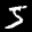

torch.Size([3, 32, 32])


In [5]:
batch_size_train = 256
batch_size_test = 256
batch_size_wm = 64

trainset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/train/', transform=transform_train)
testset = datasets.ImageFolder('./data/CIFAR10_8020/test', transform=transform_test)
# valset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/val/', transform=transform_test)
watermarkset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/trigger_random/', transform=transform_test)
advwatermarkset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/trigger_adv/', transform=transform_test)
unrelatedset = watermark_unrelated(count=100)
unrl_mixset = torch.utils.data.ConcatDataset((trainset,unrelatedset))
adv_mixset = torch.utils.data.ConcatDataset((trainset,advwatermarkset))
rand_mixset = torch.utils.data.ConcatDataset((trainset,watermarkset))

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=8)

#valloader = torch.utils.data.DataLoader(
#    valset, batch_size=batch_size_test, shuffle=False, num_workers=8)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

wmloader = torch.utils.data.DataLoader(
    watermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
unrelatedloader = torch.utils.data.DataLoader(
    unrelatedset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
advwmloader = torch.utils.data.DataLoader(
    advwatermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
unrl_mix_loader = torch.utils.data.DataLoader(
    unrl_mixset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)
adv_mix_loader = torch.utils.data.DataLoader(
    adv_mixset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)
rand_mix_loader = torch.utils.data.DataLoader(
    rand_mixset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

Random Label

In [6]:
net = ResNet18()
optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_certified_wm(
    net,
    rand_mix_loader,
    wmloader,
    testloader,
    optimizer,
    scheduler,
    cert_type='random_8020_rand',
    epochs=100,
    warmup_epochs=10
)

Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.52it/s]
/home/cysren/anaconda3/envs/wm/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 0
Train: Train acc 35.687156421789105 | WM acc 0.0
Tests: WM acc 2.0 | WM train avg acc 10.07 | Test acc 42.480000000000004
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 1
Train: Train acc 52.86606696651675 | WM acc 0.0
Tests: WM acc 4.0 | WM train avg acc 9.87 | Test acc 51.1
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:15<00:00, 10.40it/s]


Epoch 2
Train: Train acc 62.29385307346327 | WM acc 0.0
Tests: WM acc 3.0 | WM train avg acc 10.46 | Test acc 63.480000000000004
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 3
Train: Train acc 68.20089955022489 | WM acc 0.0
Tests: WM acc 5.0 | WM train avg acc 9.49 | Test acc 66.28
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


Epoch 4
Train: Train acc 72.83108445777111 | WM acc 0.0
Tests: WM acc 7.000000000000001 | WM train avg acc 10.01 | Test acc 63.959999999999994
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.69it/s]


Epoch 5
Train: Train acc 75.29985007496252 | WM acc 0.0
Tests: WM acc 7.000000000000001 | WM train avg acc 9.64 | Test acc 73.87
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 6
Train: Train acc 77.4087956021989 | WM acc 0.0
Tests: WM acc 8.0 | WM train avg acc 9.92 | Test acc 74.95
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 7
Train: Train acc 79.1904047976012 | WM acc 0.0
Tests: WM acc 9.0 | WM train avg acc 9.76 | Test acc 76.33
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


Epoch 8
Train: Train acc 80.54972513743128 | WM acc 0.0
Tests: WM acc 7.000000000000001 | WM train avg acc 9.92 | Test acc 77.41
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:17<00:00,  8.87it/s]


Epoch 9
Train: Train acc 81.74662668665668 | WM acc 0.0
Tests: WM acc 15.0 | WM train avg acc 9.72 | Test acc 78.33
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 10
Train: Train acc 82.89605197401299 | WM acc 0.0
Tests: WM acc 12.0 | WM train avg acc 9.83 | Test acc 79.97999999999999
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 11
Train: Train acc 83.26086956521739 | WM acc 17.0
Tests: WM acc 16.0 | WM train avg acc 10.0 | Test acc 80.83
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 12
Train: Train acc 83.72063968015992 | WM acc 12.0
Tests: WM acc 16.0 | WM train avg acc 9.9 | Test acc 78.82000000000001
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 13
Train: Train acc 84.6776611694153 | WM acc 11.0
Tests: WM acc 24.0 | WM train avg acc 10.14 | Test acc 78.59
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 14
Train: Train acc 85.15742128935531 | WM acc 13.0
Tests: WM acc 34.0 | WM train avg acc 10.52 | Test acc 80.57
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 15
Train: Train acc 86.1744127936032 | WM acc 8.0
Tests: WM acc 28.000000000000004 | WM train avg acc 10.35 | Test acc 81.97
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 16
Train: Train acc 86.8215892053973 | WM acc 5.0
Tests: WM acc 32.0 | WM train avg acc 9.6 | Test acc 81.98
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 17
Train: Train acc 87.5112443778111 | WM acc 16.0
Tests: WM acc 39.0 | WM train avg acc 10.64 | Test acc 83.25
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 18
Train: Train acc 87.83608195902049 | WM acc 13.0
Tests: WM acc 41.0 | WM train avg acc 10.42 | Test acc 79.82000000000001
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:15<00:00, 10.38it/s]


Epoch 19
Train: Train acc 88.57821089455273 | WM acc 9.0
Tests: WM acc 45.0 | WM train avg acc 9.83 | Test acc 81.34
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.78it/s]


Epoch 20
Train: Train acc 89.40529735132434 | WM acc 12.0
Tests: WM acc 55.00000000000001 | WM train avg acc 10.59 | Test acc 83.74000000000001
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:18<00:00,  8.43it/s]


Epoch 21
Train: Train acc 89.68515742128935 | WM acc 12.0
Tests: WM acc 57.99999999999999 | WM train avg acc 9.98 | Test acc 83.44
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:15<00:00, 10.36it/s]


Epoch 22
Train: Train acc 90.21489255372313 | WM acc 9.0
Tests: WM acc 56.00000000000001 | WM train avg acc 10.61 | Test acc 84.00999999999999
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:16<00:00,  9.78it/s]


Epoch 23
Train: Train acc 90.71964017991004 | WM acc 11.0
Tests: WM acc 56.99999999999999 | WM train avg acc 10.77 | Test acc 82.54
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:17<00:00,  9.07it/s]


Epoch 24
Train: Train acc 91.38430784607696 | WM acc 11.0
Tests: WM acc 64.0 | WM train avg acc 10.29 | Test acc 82.77
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:18<00:00,  8.51it/s]


Epoch 25
Train: Train acc 91.7216391804098 | WM acc 11.0
Tests: WM acc 70.0 | WM train avg acc 10.56 | Test acc 84.21
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:20<00:00,  7.79it/s]


Epoch 26
Train: Train acc 91.94152923538232 | WM acc 13.0
Tests: WM acc 75.0 | WM train avg acc 10.66 | Test acc 84.48
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:21<00:00,  7.18it/s]


Epoch 27
Train: Train acc 92.19140429785108 | WM acc 11.0
Tests: WM acc 74.0 | WM train avg acc 10.25 | Test acc 84.16
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.80it/s]


Epoch 28
Train: Train acc 92.94602698650675 | WM acc 11.0
Tests: WM acc 82.0 | WM train avg acc 10.75 | Test acc 83.04
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.47it/s]


Epoch 29
Train: Train acc 93.35582208895552 | WM acc 10.0
Tests: WM acc 81.0 | WM train avg acc 10.7 | Test acc 85.04
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.12it/s]


Epoch 30
Train: Train acc 93.41579210394802 | WM acc 7.000000000000001
Tests: WM acc 88.0 | WM train avg acc 10.62 | Test acc 84.08
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


Epoch 31
Train: Train acc 96.62918540729635 | WM acc 11.0
Tests: WM acc 97.0 | WM train avg acc 10.02 | Test acc 87.81
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.86it/s]


Epoch 32
Train: Train acc 97.59620189905047 | WM acc 12.0
Tests: WM acc 97.0 | WM train avg acc 10.51 | Test acc 88.18
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.78it/s]


Epoch 33
Train: Train acc 97.78110944527737 | WM acc 8.0
Tests: WM acc 98.0 | WM train avg acc 10.19 | Test acc 87.86
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 34
Train: Train acc 98.07346326836581 | WM acc 8.0
Tests: WM acc 97.0 | WM train avg acc 10.28 | Test acc 87.91
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 35
Train: Train acc 98.14592703648177 | WM acc 4.0
Tests: WM acc 98.0 | WM train avg acc 10.46 | Test acc 88.01
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 36
Train: Train acc 98.2583708145927 | WM acc 9.0
Tests: WM acc 99.0 | WM train avg acc 9.88 | Test acc 87.86
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 37
Train: Train acc 98.39580209895053 | WM acc 12.0
Tests: WM acc 99.0 | WM train avg acc 10.59 | Test acc 88.29
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 38
Train: Train acc 98.53073463268366 | WM acc 4.0
Tests: WM acc 99.0 | WM train avg acc 10.76 | Test acc 88.13
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 39
Train: Train acc 98.6431784107946 | WM acc 9.0
Tests: WM acc 100.0 | WM train avg acc 10.55 | Test acc 88.22
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 40
Train: Train acc 98.67316341829086 | WM acc 8.0
Tests: WM acc 99.0 | WM train avg acc 10.26 | Test acc 88.09
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 41
Train: Train acc 98.7631184407796 | WM acc 9.0
Tests: WM acc 100.0 | WM train avg acc 10.77 | Test acc 88.28
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 42
Train: Train acc 98.86306846576711 | WM acc 7.000000000000001
Tests: WM acc 100.0 | WM train avg acc 10.9 | Test acc 88.17
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 43
Train: Train acc 98.86306846576711 | WM acc 8.0
Tests: WM acc 100.0 | WM train avg acc 10.75 | Test acc 88.32
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 44
Train: Train acc 99.02048975512244 | WM acc 9.0
Tests: WM acc 100.0 | WM train avg acc 10.27 | Test acc 88.28
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 45
Train: Train acc 99.05797101449275 | WM acc 10.0
Tests: WM acc 100.0 | WM train avg acc 10.37 | Test acc 88.35
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.61it/s]


Epoch 46
Train: Train acc 99.13293353323338 | WM acc 10.0
Tests: WM acc 100.0 | WM train avg acc 10.64 | Test acc 88.18
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 47
Train: Train acc 99.20039980009994 | WM acc 9.0
Tests: WM acc 100.0 | WM train avg acc 9.99 | Test acc 88.21
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 48
Train: Train acc 99.19040479760119 | WM acc 13.0
Tests: WM acc 100.0 | WM train avg acc 10.59 | Test acc 88.47
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 49
Train: Train acc 99.26286856571714 | WM acc 11.0
Tests: WM acc 100.0 | WM train avg acc 10.53 | Test acc 88.48
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 50
Train: Train acc 99.30284857571215 | WM acc 13.0
Tests: WM acc 100.0 | WM train avg acc 10.11 | Test acc 88.23
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 51
Train: Train acc 99.33533233383308 | WM acc 13.0
Tests: WM acc 100.0 | WM train avg acc 11.16 | Test acc 88.33
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 52
Train: Train acc 99.32283858070964 | WM acc 9.0
Tests: WM acc 100.0 | WM train avg acc 10.57 | Test acc 88.26
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 53
Train: Train acc 99.33033483258372 | WM acc 9.0
Tests: WM acc 100.0 | WM train avg acc 10.12 | Test acc 88.29
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 54
Train: Train acc 99.42528735632183 | WM acc 12.0
Tests: WM acc 100.0 | WM train avg acc 10.26 | Test acc 88.32
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 55
Train: Train acc 99.52273863068466 | WM acc 13.0
Tests: WM acc 100.0 | WM train avg acc 10.32 | Test acc 88.44999999999999
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 56
Train: Train acc 99.49775112443778 | WM acc 6.0
Tests: WM acc 100.0 | WM train avg acc 10.62 | Test acc 88.34
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 57
Train: Train acc 99.50274862568716 | WM acc 8.0
Tests: WM acc 100.0 | WM train avg acc 10.11 | Test acc 88.31
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 58
Train: Train acc 99.52523738130935 | WM acc 12.0
Tests: WM acc 100.0 | WM train avg acc 11.17 | Test acc 88.46000000000001
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 59
Train: Train acc 99.53023488255872 | WM acc 15.0
Tests: WM acc 100.0 | WM train avg acc 10.02 | Test acc 88.42
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 60
Train: Train acc 99.6351824087956 | WM acc 7.000000000000001
Tests: WM acc 100.0 | WM train avg acc 10.68 | Test acc 88.25
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 61
Train: Train acc 99.60769615192405 | WM acc 15.0
Tests: WM acc 100.0 | WM train avg acc 10.49 | Test acc 88.22
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 62
Train: Train acc 99.68515742128935 | WM acc 8.0
Tests: WM acc 100.0 | WM train avg acc 10.91 | Test acc 88.41
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 63
Train: Train acc 99.70014992503748 | WM acc 9.0
Tests: WM acc 100.0 | WM train avg acc 10.21 | Test acc 88.42999999999999
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 64
Train: Train acc 99.67266366816591 | WM acc 7.000000000000001
Tests: WM acc 100.0 | WM train avg acc 10.34 | Test acc 88.3
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 65
Train: Train acc 99.73263368315843 | WM acc 7.000000000000001
Tests: WM acc 100.0 | WM train avg acc 10.51 | Test acc 88.4
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 66
Train: Train acc 99.68515742128935 | WM acc 17.0
Tests: WM acc 100.0 | WM train avg acc 10.74 | Test acc 88.44
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 67
Train: Train acc 99.73513243378311 | WM acc 11.0
Tests: WM acc 100.0 | WM train avg acc 10.6 | Test acc 88.41
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 68
Train: Train acc 99.70514742628686 | WM acc 6.0
Tests: WM acc 100.0 | WM train avg acc 10.58 | Test acc 88.42
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 69
Train: Train acc 99.73013493253373 | WM acc 17.0
Tests: WM acc 100.0 | WM train avg acc 10.56 | Test acc 88.31
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 70
Train: Train acc 99.68515742128935 | WM acc 13.0
Tests: WM acc 100.0 | WM train avg acc 11.18 | Test acc 88.53999999999999
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 71
Train: Train acc 99.76261869065468 | WM acc 9.0
Tests: WM acc 100.0 | WM train avg acc 10.74 | Test acc 88.36
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 72
Train: Train acc 99.72763618190903 | WM acc 16.0
Tests: WM acc 100.0 | WM train avg acc 10.85 | Test acc 88.44
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 73
Train: Train acc 99.76261869065468 | WM acc 11.0
Tests: WM acc 100.0 | WM train avg acc 10.72 | Test acc 88.42999999999999
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 74
Train: Train acc 99.76761619190405 | WM acc 9.0
Tests: WM acc 100.0 | WM train avg acc 10.5 | Test acc 88.53
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 75
Train: Train acc 99.72013993003497 | WM acc 11.0
Tests: WM acc 100.0 | WM train avg acc 10.62 | Test acc 88.53
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 76
Train: Train acc 99.79510244877561 | WM acc 16.0
Tests: WM acc 100.0 | WM train avg acc 10.62 | Test acc 88.36
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 77
Train: Train acc 99.75012493753124 | WM acc 12.0
Tests: WM acc 100.0 | WM train avg acc 10.56 | Test acc 88.49000000000001
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 78
Train: Train acc 99.68015992003998 | WM acc 16.0
Tests: WM acc 100.0 | WM train avg acc 10.23 | Test acc 88.42
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 79
Train: Train acc 99.76761619190405 | WM acc 9.0
Tests: WM acc 100.0 | WM train avg acc 10.51 | Test acc 88.47
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 80
Train: Train acc 99.78510744627687 | WM acc 8.0
Tests: WM acc 100.0 | WM train avg acc 10.28 | Test acc 88.47
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 81
Train: Train acc 99.77261369315342 | WM acc 10.0
Tests: WM acc 100.0 | WM train avg acc 10.43 | Test acc 88.53999999999999
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 82
Train: Train acc 99.72513743128437 | WM acc 10.0
Tests: WM acc 100.0 | WM train avg acc 10.7 | Test acc 88.44999999999999
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 83
Train: Train acc 99.75262368815592 | WM acc 7.000000000000001
Tests: WM acc 100.0 | WM train avg acc 10.66 | Test acc 88.47
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 84
Train: Train acc 99.74012993503248 | WM acc 12.0
Tests: WM acc 100.0 | WM train avg acc 10.85 | Test acc 88.47
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 85
Train: Train acc 99.77011494252874 | WM acc 8.0
Tests: WM acc 100.0 | WM train avg acc 10.3 | Test acc 88.42999999999999
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 86
Train: Train acc 99.76511744127936 | WM acc 19.0
Tests: WM acc 100.0 | WM train avg acc 10.4 | Test acc 88.48
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 87
Train: Train acc 99.73013493253373 | WM acc 12.0
Tests: WM acc 100.0 | WM train avg acc 10.24 | Test acc 88.47
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 88
Train: Train acc 99.77261369315342 | WM acc 11.0
Tests: WM acc 100.0 | WM train avg acc 10.53 | Test acc 88.48
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 89
Train: Train acc 99.78010994502749 | WM acc 13.0
Tests: WM acc 100.0 | WM train avg acc 10.62 | Test acc 88.41
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 90
Train: Train acc 99.78760619690155 | WM acc 13.0
Tests: WM acc 100.0 | WM train avg acc 10.12 | Test acc 88.55
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 91
Train: Train acc 99.79510244877561 | WM acc 17.0
Tests: WM acc 100.0 | WM train avg acc 10.24 | Test acc 88.53999999999999
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 92
Train: Train acc 99.7551224387806 | WM acc 12.0
Tests: WM acc 100.0 | WM train avg acc 10.45 | Test acc 88.58
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 93
Train: Train acc 99.77261369315342 | WM acc 11.0
Tests: WM acc 100.0 | WM train avg acc 10.67 | Test acc 88.55
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 94
Train: Train acc 99.78260869565217 | WM acc 5.0
Tests: WM acc 100.0 | WM train avg acc 10.5 | Test acc 88.55
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 95
Train: Train acc 99.77011494252874 | WM acc 9.0
Tests: WM acc 100.0 | WM train avg acc 10.55 | Test acc 88.55
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 96
Train: Train acc 99.78010994502749 | WM acc 13.0
Tests: WM acc 100.0 | WM train avg acc 10.53 | Test acc 88.6
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 97
Train: Train acc 99.81009495252374 | WM acc 11.0
Tests: WM acc 100.0 | WM train avg acc 10.05 | Test acc 88.53
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 98
Train: Train acc 99.7776111944028 | WM acc 12.0
Tests: WM acc 100.0 | WM train avg acc 10.5 | Test acc 88.42
./models/wm_cifar10_certify_random_8020_rand.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 99
Train: Train acc 99.76011994003 | WM acc 11.0
Tests: WM acc 100.0 | WM train avg acc 10.55 | Test acc 88.55
./models/wm_cifar10_certify_random_8020_rand.pth


Unrelated 

In [ ]:
net = ResNet18()
optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_certified_wm(
    net,
    unrl_mix_loader,
    unrelatedloader,
    testloader,
    optimizer,
    scheduler,
    cert_type='random_8020_unrl',
    epochs=100,
    warmup_epochs=10
)

Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 0
Train: Train acc 37.4687656171914 | WM acc 0.0
Tests: WM acc 98.0 | WM train avg acc 13.05 | Test acc 41.870000000000005
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:15<00:00, 10.41it/s]


Epoch 1
Train: Train acc 54.835082458770614 | WM acc 0.0
Tests: WM acc 76.0 | WM train avg acc 9.81 | Test acc 51.800000000000004
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 2
Train: Train acc 64.37281359320339 | WM acc 0.0
Tests: WM acc 13.0 | WM train avg acc 8.83 | Test acc 64.34
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


Epoch 3
Train: Train acc 69.98500749625187 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 5.15 | Test acc 69.59
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.74it/s]


Epoch 4
Train: Train acc 74.53773113443279 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 7.35 | Test acc 74.16
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


Epoch 5
Train: Train acc 76.95652173913044 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 16.18 | Test acc 73.3
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 6
Train: Train acc 78.71314342828586 | WM acc 0.0
Tests: WM acc 99.0 | WM train avg acc 8.81 | Test acc 72.05
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.71it/s]


Epoch 7
Train: Train acc 80.83958020989506 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 14.44 | Test acc 78.51
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:15<00:00,  9.86it/s]


Epoch 8
Train: Train acc 81.79660169915043 | WM acc 0.0
Tests: WM acc 75.0 | WM train avg acc 11.4 | Test acc 78.58000000000001
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 9
Train: Train acc 82.90104947526237 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 9.24 | Test acc 78.72
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


Epoch 10
Train: Train acc 84.01549225387306 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 8.99 | Test acc 75.76
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


Epoch 11
Train: Train acc 34.342828585707146 | WM acc 36.0
Tests: WM acc 70.0 | WM train avg acc 0.0 | Test acc 51.24999999999999
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


Epoch 12
Train: Train acc 57.52623688155922 | WM acc 100.0
Tests: WM acc 66.0 | WM train avg acc 61.24 | Test acc 68.27
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.68it/s]


Epoch 13
Train: Train acc 72.51874062968515 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 68.38 | Test acc 73.39
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.68it/s]


Epoch 14
Train: Train acc 77.94602698650675 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 71.7 | Test acc 76.55999999999999
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 15
Train: Train acc 80.20989505247377 | WM acc 93.0
Tests: WM acc 100.0 | WM train avg acc 79.94 | Test acc 78.03
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.68it/s]


Epoch 16
Train: Train acc 82.74362818590704 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 79.84 | Test acc 79.3
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 17
Train: Train acc 83.2783608195902 | WM acc 100.0
Tests: WM acc 94.0 | WM train avg acc 77.08 | Test acc 75.99000000000001
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


Epoch 18
Train: Train acc 84.60769615192405 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 80.59 | Test acc 78.96
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:17<00:00,  9.12it/s]


Epoch 19
Train: Train acc 85.43228385807097 | WM acc 96.0
Tests: WM acc 100.0 | WM train avg acc 77.33 | Test acc 79.65
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:15<00:00, 10.37it/s]


Epoch 20
Train: Train acc 85.67716141929036 | WM acc 42.0
Tests: WM acc 100.0 | WM train avg acc 85.61 | Test acc 81.95
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:20<00:00,  7.52it/s]


Epoch 21
Train: Train acc 87.00899550224888 | WM acc 83.0
Tests: WM acc 90.0 | WM train avg acc 77.5 | Test acc 81.62
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.61it/s]


Epoch 22
Train: Train acc 87.80359820089954 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 79.28 | Test acc 83.06
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 23
Train: Train acc 88.11094452773614 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 81.64 | Test acc 81.51
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.79it/s]


Epoch 24
Train: Train acc 88.24587706146927 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 82.73 | Test acc 80.99
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.79it/s]


Epoch 25
Train: Train acc 89.13543228385808 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 87.96 | Test acc 83.82
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.97it/s]


Epoch 26
Train: Train acc 89.55022488755621 | WM acc 100.0
Tests: WM acc 92.0 | WM train avg acc 81.38 | Test acc 84.3
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.27it/s]


Epoch 27
Train: Train acc 90.22488755622189 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 87.67 | Test acc 85.11999999999999
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.52it/s]


Epoch 28
Train: Train acc 90.63968015992005 | WM acc 100.0
Tests: WM acc 99.0 | WM train avg acc 85.76 | Test acc 81.58999999999999
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.65it/s]


Epoch 29
Train: Train acc 90.8095952023988 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.07 | Test acc 83.96000000000001
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:22<00:00,  6.84it/s]


Epoch 30
Train: Train acc 91.32183908045977 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 87.39 | Test acc 83.72
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:21<00:00,  7.20it/s]


Epoch 31
Train: Train acc 94.48525737131435 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 84.04 | Test acc 87.77000000000001
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:21<00:00,  7.37it/s]


Epoch 32
Train: Train acc 95.55972013993004 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.94 | Test acc 87.75
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:20<00:00,  7.66it/s]


Epoch 33
Train: Train acc 95.96701649175412 | WM acc 77.0
Tests: WM acc 100.0 | WM train avg acc 87.93 | Test acc 88.16000000000001
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:19<00:00,  7.85it/s]


Epoch 34
Train: Train acc 96.151924037981 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.48 | Test acc 87.96000000000001
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:19<00:00,  8.11it/s]


Epoch 35
Train: Train acc 96.47176411794104 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.76 | Test acc 87.85
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:18<00:00,  8.46it/s]


Epoch 36
Train: Train acc 96.56421789105447 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 93.0 | Test acc 88.0
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:18<00:00,  8.57it/s]


Epoch 37
Train: Train acc 96.78910544727636 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 87.19 | Test acc 88.17
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:17<00:00,  8.75it/s]


Epoch 38
Train: Train acc 96.93403298350825 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.77 | Test acc 88.22
./models/wm_cifar10_certify_random_8020_unrl.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:17<00:00,  8.94it/s]


Epoch 39
Train: Train acc 97.06146926536732 | WM acc 91.0
Tests: WM acc 100.0 | WM train avg acc 90.75 | Test acc 88.12
./models/wm_cifar10_certify_random_8020_unrl.pth


Robust training:   0%|                                                                         | 0/2 [00:00<?, ?it/s]

Adversarial

In [ ]:
net = ResNet18()
optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_certified_wm(
    net,
    adv_mix_loader,
    advwmloader,
    testloader,
    optimizer,
    scheduler,
    cert_type='random_8020_adv',
    epochs=100,
    warmup_epochs=10
)